Vietnamese Traffic Sign Recognition with Deep Learning

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Dataset
class TrafficDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for idx, label in enumerate(self.classes):
            class_folder = os.path.join(root_dir, label)
            for img_file in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img_file))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


In [2]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset loading from a single directory and splitting into train/test
# full_dataset = TrafficDataset(r'C:\Master\Vietnamese-Traffic-Sign\myData', transform=transform)
# Please update the path below with the correct path to your dataset in Google Drive
full_dataset = TrafficDataset(r'D:/2025/Vietnamese-Traffic-Sign/myData', transform=transform)
#train_size = int(0.8 * len(full_dataset))
#test_size = len(full_dataset) - train_size
#train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Chia tỉ lệ 80% train, 10% val, 10% test
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [3]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


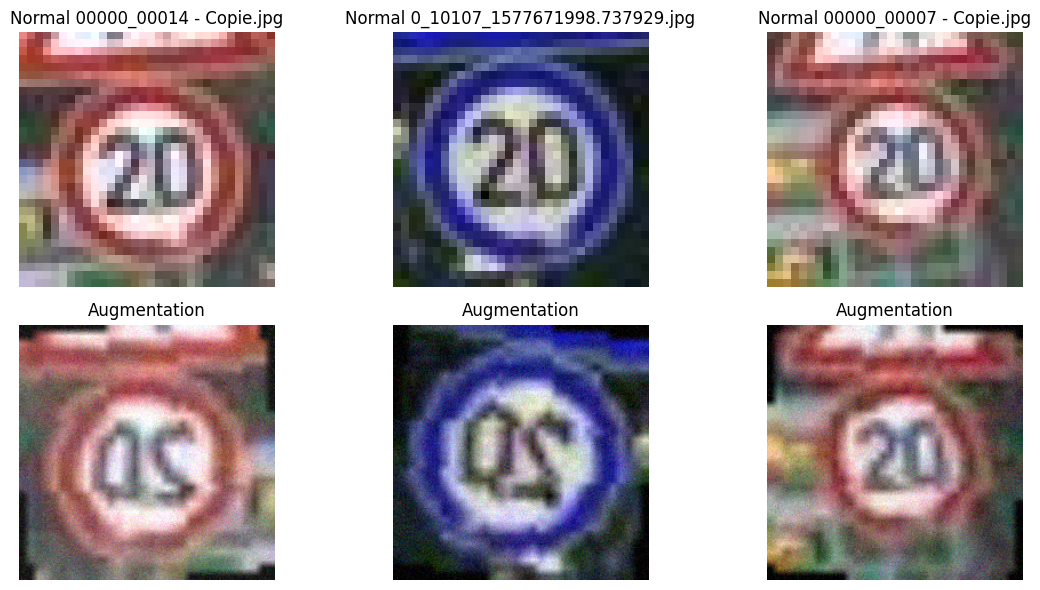

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

# Thêm nhiễu Gaussian
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# Biến đổi ảnh (augmentation)
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Đường dẫn đến ảnh gốc
image_dir = r"D:\2025\Vietnamese-Traffic-Sign\myData\0"
image_files = random.sample(os.listdir(image_dir), 3)

# Vẽ 3 cặp hình: gốc - augmentation
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, img_file in enumerate(image_files):
    path = os.path.join(image_dir, img_file)
    image = Image.open(path).convert("RGB")
    aug = train_transform(image).permute(1, 2, 0).numpy()
    aug = (aug * 0.5 + 0.5).clip(0, 1)  # Chuẩn hóa lại

    axs[0, i].imshow(image)
    axs[0, i].set_title(f"Normal {img_file}")
    axs[0, i].axis("off")

    axs[1, i].imshow(aug)
    axs[1, i].set_title("Augmentation")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()



In [5]:
# Load toàn bộ chỉ để lấy danh sách và chia chỉ số
from torch.utils.data import Subset

full_dataset = TrafficDataset(r'D:/2025/Vietnamese-Traffic-Sign/myData', transform=None)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
indices = torch.randperm(len(full_dataset)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# Gán lại transform đúng
train_dataset = Subset(TrafficDataset('D:/2025/Vietnamese-Traffic-Sign/myData', transform=train_transform), train_indices)
val_dataset   = Subset(TrafficDataset('D:/2025/Vietnamese-Traffic-Sign/myData', transform=test_transform), val_indices)
test_dataset  = Subset(TrafficDataset('D:/2025/Vietnamese-Traffic-Sign/myData', transform=test_transform), test_indices)

# ✅ DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
print(" Số lượng ảnh trong từng tập dữ liệu:")
print(f"  - Train: {len(train_dataset)} ảnh")
print(f"  - Validation: {len(val_dataset)} ảnh")
print(f"  - Test: {len(test_dataset)} ảnh")


 Số lượng ảnh trong từng tập dữ liệu:
  - Train: 36383 ảnh
  - Validation: 4547 ảnh
  - Test: 4549 ảnh


In [7]:
# Vision Transformer model
from torchvision.models.vision_transformer import vit_b_16
model = vit_b_16(weights=None)
model.heads.head = nn.Linear(model.heads.head.in_features, len(full_dataset.classes))

# Loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Epoch 1/50, Train Loss: 2.3409, Train Acc: 0.2537, Val Loss: 1.7220, Val Acc: 0.3926
Epoch 2/50, Train Loss: 1.5033, Train Acc: 0.4667, Val Loss: 1.1474, Val Acc: 0.5857
Epoch 3/50, Train Loss: 1.0264, Train Acc: 0.6374, Val Loss: 0.7415, Val Acc: 0.7422
Epoch 4/50, Train Loss: 0.7494, Train Acc: 0.7388, Val Loss: 0.4843, Val Acc: 0.8417
Epoch 5/50, Train Loss: 0.5879, Train Acc: 0.7946, Val Loss: 0.3820, Val Acc: 0.8724
Epoch 6/50, Train Loss: 0.4803, Train Acc: 0.8353, Val Loss: 0.3419, Val Acc: 0.8749
Epoch 7/50, Train Loss: 0.4064, Train Acc: 0.8591, Val Loss: 0.3280, Val Acc: 0.8874
Epoch 8/50, Train Loss: 0.3550, Train Acc: 0.8766, Val Loss: 0.2323, Val Acc: 0.9177
Epoch 9/50, Train Loss: 0.3140, Train Acc: 0.8946, Val Loss: 0.2135, Val Acc: 0.9272
Epoch 10/50, Train Loss: 0.2736, Train Acc: 0.9059, Val Loss: 0.2002, Val Acc: 0.9340
Epoch 11/50, Train Loss: 0.2751, Train Acc: 0.9072, Val Loss: 0.3363, Val Acc: 0.8806
Epoch 12/50, Train Loss: 0.2530, Train Acc: 0.9138, Val Loss: 0

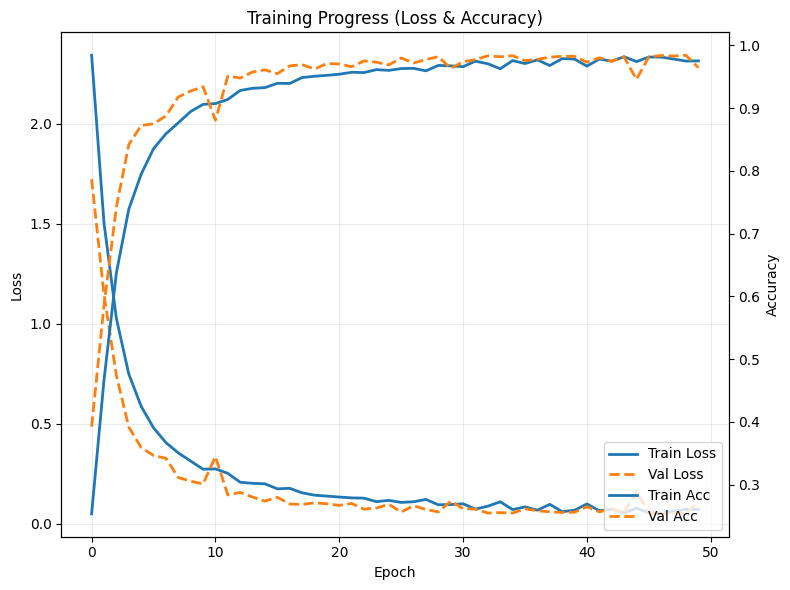

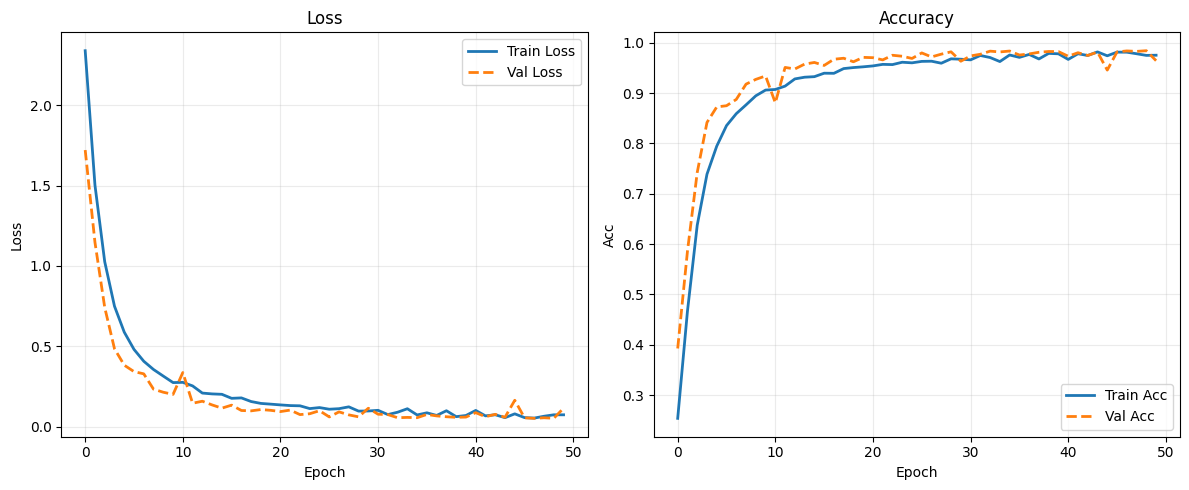

In [ ]:
# ============================================
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)

train_loss_history, val_loss_history = [], []
train_acc_history,  val_acc_history  = [], []

epochs = 50

for epoch in range(epochs):
    # -------- Train --------
    model.train()
    tr_loss_sum, tr_correct, tr_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        bs = labels.size(0)
        tr_loss_sum += loss.item() * bs

        _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels).sum().item()
        tr_total   += bs

    epoch_train_loss = tr_loss_sum / max(tr_total, 1)
    epoch_train_acc  = tr_correct / max(tr_total, 1)

    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc)

    # -------- Validation --------
    model.eval()
    val_loss_sum, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            bs = labels.size(0)
            val_loss_sum += loss.item() * bs

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total   += bs

    epoch_val_loss = val_loss_sum / max(val_total, 1)
    epoch_val_acc  = val_correct / max(val_total, 1)

    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")


# Lưu log ra CSV
# ============================================
import pandas as pd
log_df = pd.DataFrame({
    "epoch": np.arange(1, epochs+1),
    "train_loss": train_loss_history,
    "val_loss":   val_loss_history,
    "train_acc":  train_acc_history,
    "val_acc":    val_acc_history
})
log_df.to_csv("outputs/vit_training_log.csv", index=False)
print("Saved training log -> outputs/vit_training_log.csv")


# Vẽ biểu đồ (Loss & Acc cho Train/Val)
# ============================================
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# Loss (trục trái)
l1, = ax1.plot(train_loss_history, label="Train Loss", linewidth=2)
l2, = ax1.plot(val_loss_history,   label="Val Loss",   linewidth=2, linestyle="--")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True, alpha=0.25)

# Acc (trục phải)
l3, = ax2.plot(train_acc_history,  label="Train Acc", linewidth=2)
l4, = ax2.plot(val_acc_history,    label="Val Acc",   linewidth=2, linestyle="--")
ax2.set_ylabel("Accuracy")

# Gộp legend
lines = [l1, l2, l3, l4]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="lower right")

plt.title("Training Progress (Loss & Accuracy)")
plt.tight_layout()
plt.savefig("outputs/vit_train_val_curves.png", dpi=150)
plt.show()

# ============================================
fig, (axA, axB) = plt.subplots(1, 2, figsize=(12, 5))
axA.plot(train_loss_history, label="Train Loss", linewidth=2)
axA.plot(val_loss_history,   label="Val Loss",   linewidth=2, linestyle="--")
axA.set_title("Loss"); axA.set_xlabel("Epoch"); axA.set_ylabel("Loss"); axA.grid(True, alpha=0.25); axA.legend()

axB.plot(train_acc_history, label="Train Acc", linewidth=2)
axB.plot(val_acc_history,   label="Val Acc",   linewidth=2, linestyle="--")
axB.set_title("Accuracy"); axB.set_xlabel("Epoch"); axB.set_ylabel("Acc"); axB.grid(True, alpha=0.25); axB.legend()

plt.tight_layout()
plt.savefig("outputs/vit_train_val_subplots.png", dpi=150)
plt.show()


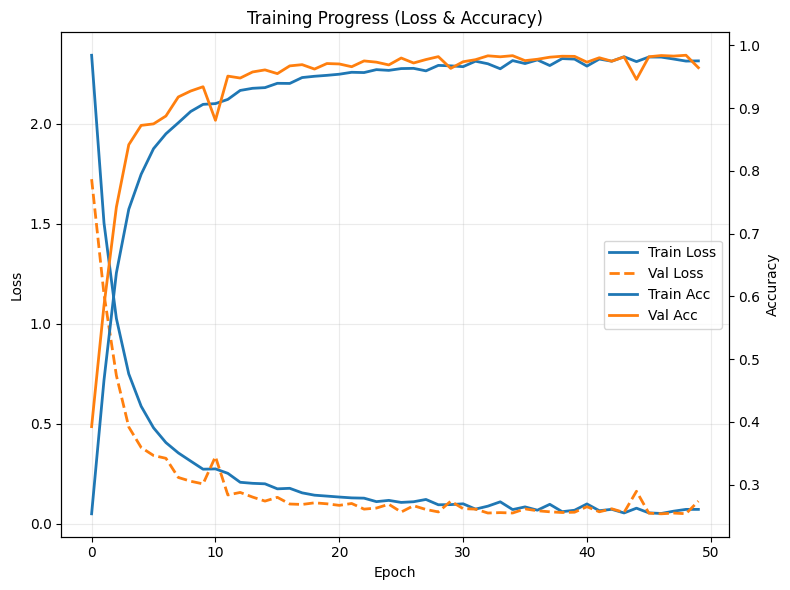

In [ ]:
# Vẽ biểu đồ (Loss & Acc cho Train/Val)
# ============================================
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# Loss (trục trái)
l1, = ax1.plot(train_loss_history, label="Train Loss", linewidth=2)
l2, = ax1.plot(val_loss_history,   label="Val Loss",   linewidth=2, linestyle="--")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True, alpha=0.25)

# Acc (trục phải)
l3, = ax2.plot(train_acc_history,  label="Train Acc", linewidth=2)
l4, = ax2.plot(val_acc_history,    label="Val Acc",   linewidth=2)
ax2.set_ylabel("Accuracy")

# Gộp legend
lines = [l1, l2, l3, l4]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="center right")

plt.title("Training Progress (Loss & Accuracy)")
plt.tight_layout()
plt.savefig("outputs/vit_train_val_curves.png", dpi=150)
plt.show()

In [12]:
# Save model
os.makedirs('outputs', exist_ok=True)
torch.save(model.state_dict(), 'outputs/vit_model1.pth')

In [14]:
# Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification report
print("Classification Report:")
report_str = classification_report(y_true, y_pred, target_names=full_dataset.classes)
print(report_str)

# Save classification report to file
with open("outputs/classification_report.txt", "w") as f:
    f.write(report_str)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.97      0.95      0.96       513
          10       0.98      0.99      0.98       252
          11       0.99      0.99      0.99       178
          12       0.97      1.00      0.99       199
          13       0.96      0.98      0.97        50
          14       0.97      0.96      0.97       257
          15       0.98      1.00      0.99       110
          16       0.93      0.97      0.95        91
          17       1.00      0.93      0.96        40
          18       0.98      0.98      0.98       122
          19       0.95      1.00      0.98        82
           2       0.92      0.94      0.93       262
          20       0.97      0.96      0.97       216
          21       0.99      0.85      0.91        87
          22       0.91      0.98      0.94        52
          23       1.00      0.98      0.99        66
    

In [15]:
# ✅ Tính Test Accuracy
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
test_acc = test_correct / test_total
print(f"✅ Test Accuracy: {test_acc:.4f}")

✅ Test Accuracy: 0.9655


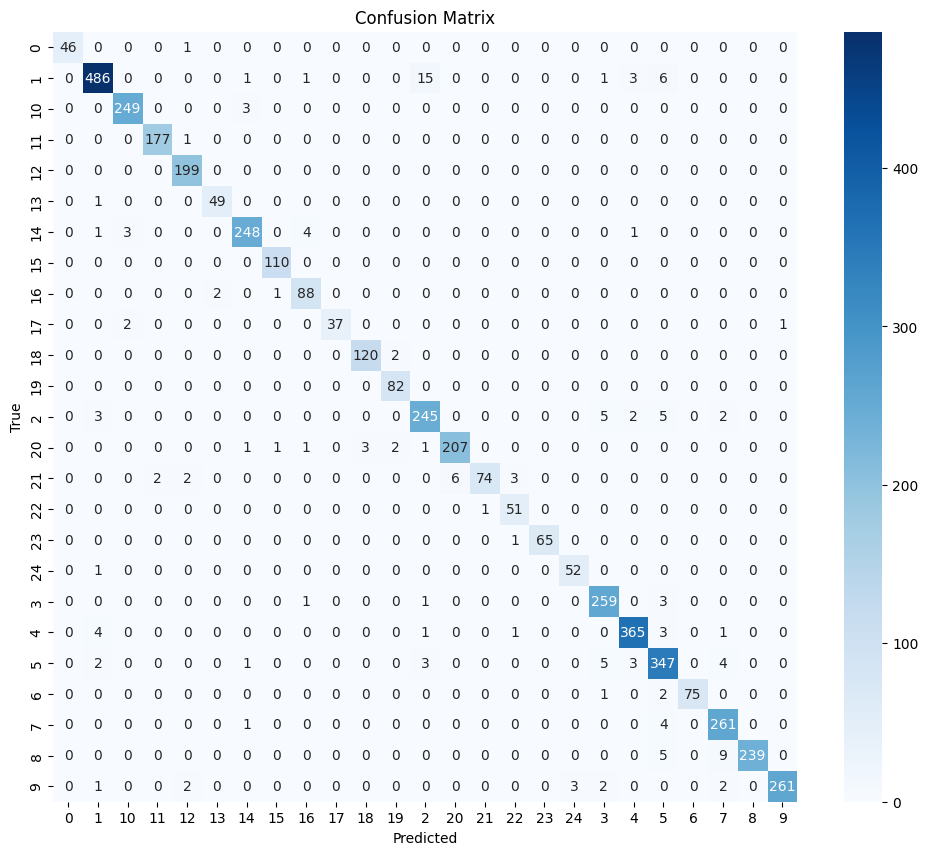

In [16]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('outputs/confusion_matrix.png')
plt.show()

API Streamlit

In [1]:
# ViT Streamlit UI deps
!pip install -q streamlit torch torchvision pillow numpy scikit-learn matplotlib seaborn pandas


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%%writefile app_streamlit_vit.py
import os, io, time, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models.vision_transformer import vit_b_16

import streamlit as st

st.set_page_config(page_title="Traffic Sign Classification - ViT", layout="wide")

# Sidebar: cấu hình
# ==============================
st.sidebar.title("Cấu hình (ViT)")
vit_ckpt_path = st.sidebar.text_input("Đường dẫn ViT checkpoint (.pth)", value="D:/2025/ViT_Code/outputs/vit_model1.pth")

st.sidebar.markdown("Nguồn tên lớp & CSV")
labels_csv_path = st.sidebar.text_input("Đường dẫn labels.csv", value=r"D:/2025/Vietnamese-Traffic-Sign/labels.csv")

st.sidebar.markdown("Chuẩn hoá ảnh đầu vào")
norm_choice = st.sidebar.selectbox("Chọn chuẩn hoá", ["Symmetric [-1,1] (0.5/0.5)", "ImageNet (0.485/0.229)"], index=0)
imgsz = st.sidebar.number_input("Kích thước ảnh", min_value=64, max_value=640, value=224, step=32)
show_top5 = st.sidebar.checkbox("Hiển thị Top-5", value=True)
topk = 5 if show_top5 else 1
use_gpu = st.sidebar.checkbox("Dùng GPU (nếu có)", value=True)
show_saliency = st.sidebar.checkbox("Hiển thị bản đồ chú ý (Saliency)", value=True)
saliency_overlay_alpha = st.sidebar.slider("Độ đậm overlay", 0.1, 0.9, 0.45, 0.05)

# Load labels.csv ROBUST + tạo class_names (folder order)
# ==============================
def _clean_path(p: str):
    if p is None: return None
    return os.path.expanduser(str(p)).strip().strip('"').strip("'")

def _normalize(colname: str):
    return re.sub(r'[^a-z0-9]+', '', colname.lower().strip())

@st.cache_data(show_spinner=False)
def load_label_maps(csv_path):
    csv_path = _clean_path(csv_path)
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"Không tìm thấy labels.csv: {csv_path}")

    # auto delimiter + BOM
    df = pd.read_csv(csv_path, encoding="utf-8-sig", sep=None, engine="python", na_filter=False)
    df = df.rename(columns={c: _normalize(c) for c in df.columns})

    id_candidates   = ['idclass','classId','class','id','idx','index','classidx','classindex']
    name_candidates = ['Name','label','classname','class_name','ten','tenbienbao','ten_bien_bao',
                       'signname','classlabel','viname','vietnamese','vi']

    id_col = next((c for c in id_candidates if c in df.columns), None)
    nm_col = next((c for c in name_candidates if c in df.columns), None)

    if id_col is None or nm_col is None:
        if df.shape[1] >= 2:
            id_col = id_col or list(df.columns)[0]
            nm_col = nm_col or list(df.columns)[1]
        else:
            raise ValueError("labels.csv cần tối thiểu 2 cột (ID và Name).")

    df2 = df[[id_col, nm_col]].copy()
    df2[id_col] = pd.to_numeric(df2[id_col], errors="coerce")
    df2 = df2.dropna(subset=[id_col])
    df2[id_col] = df2[id_col].astype(int)

    # Map: id(int) -> display name
    class_id_to_name = {int(r[id_col]): str(r[nm_col]) for _, r in df2.iterrows()}

    # class_names (folder order)
    id_strings = sorted([str(i) for i in class_id_to_name.keys()])
    class_names = id_strings

    debug = {
        "csv": csv_path,
        "cols": list(df.columns),
        "use_id_col": id_col,
        "use_name_col": nm_col,
        "n_classes": len(class_names),
        "preview": {i: class_id_to_name[int(s)] for i, s in list(enumerate(class_names))[:5]}
    }
    return class_id_to_name, class_names, debug

try:
    class_id_to_name, class_names, dbg = load_label_maps(labels_csv_path)
except Exception as e:
    st.error(f"Lỗi load labels.csv: {e}")
    st.stop()

num_classes = len(class_names)
st.sidebar.success(f"CSV loaded • classes={num_classes}")
st.sidebar.code("\n".join([f"{i}: {class_names[i]} -> {class_id_to_name.get(int(class_names[i]), '?')}"
                           for i in range(min(5, num_classes))]), language="text")

# Load ViT & transform
# ==============================
device_str = "cuda" if (use_gpu and torch.cuda.is_available()) else "cpu"

def load_vit(ckpt_path: str, num_classes: int, device: str):
    model = vit_b_16(weights=None)
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    map_loc = "cuda" if (device == "cuda" and torch.cuda.is_available()) else "cpu"

    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Không tìm thấy ViT checkpoint: {ckpt_path}")

    state = torch.load(ckpt_path, map_location=map_loc)
    if isinstance(state, dict) and "state_dict" in state:
        state = state["state_dict"]

    
    expected = None
    for k in ["heads.head.weight","head.weight","fc.weight","classifier.weight"]:
        if isinstance(state, dict) and k in state:
            expected = int(state[k].shape[0]); break
    if expected is not None and expected != num_classes:
        st.warning(f"⚠️ Checkpoint có {expected} lớp, label map hiện {num_classes} lớp. Hãy chắc CSV đúng cùng phiên bản train.")

    model.load_state_dict(state, strict=True)
    model.eval().to(map_loc)
    return model

vit_model = load_vit(vit_ckpt_path, num_classes, device_str)

if norm_choice.startswith("ImageNet"):
    vit_tf = transforms.Compose([
        transforms.Resize((imgsz, imgsz)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    ])
else:
    vit_tf = transforms.Compose([
        transforms.Resize((imgsz, imgsz)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
    ])

# Dự đoán
# ==============================
def predict_vit_api_style(pil_img: Image.Image, topk: int = 5):
    input_tensor = vit_tf(pil_img).unsqueeze(0).to(device_str)
    with torch.no_grad():
        output = vit_model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        predicted_class_index = int(torch.argmax(probabilities).item())
        confidence = float(probabilities[predicted_class_index].item())

    # Map: index -> folder_name (class_names) -> display name (CSV)
    predicted_folder_name = class_names[predicted_class_index]
    predicted_display_name = class_id_to_name.get(int(predicted_folder_name), "Unknown")

    # Top-K
    k = min(topk, num_classes)
    topk_prob, topk_idx = torch.topk(probabilities, k=k)
    topk_prob = topk_prob.detach().cpu().numpy().tolist()
    topk_idx = [int(i) for i in topk_idx.detach().cpu().numpy().tolist()]
    topk_pairs = []
    for idx, p in zip(topk_idx, topk_prob):
        folder = class_names[idx]
        display = class_id_to_name.get(int(folder), folder)
        topk_pairs.append((display, float(p)))

    return {
        "top1_index": predicted_class_index,
        "top1_folder": predicted_folder_name,
        "top1_name": predicted_display_name,
        "top1_conf": confidence,
        "topk": topk_pairs
    }

# === ViT Saliency (input-gradient) ===
def vit_saliency_map(pil_img: Image.Image, target_index: int, alpha: float = 0.45):
    x = vit_tf(pil_img).unsqueeze(0).to(device_str)
    x.requires_grad = True
    vit_model.zero_grad(set_to_none=True)
    logits = vit_model(x)
    score = logits[0, target_index]
    score.backward()
    grads = x.grad.detach().abs().squeeze(0).mean(dim=0).cpu().numpy()
    g_min, g_max = grads.min(), grads.max()
    grads_norm = (grads - g_min) / (g_max - g_min) if g_max > g_min else np.zeros_like(grads)
    img = pil_img.resize((grads_norm.shape[1], grads_norm.shape[0]))
    img_np = np.array(img).astype(np.float32) / 255.0
    heat = plt.get_cmap('jet')(grads_norm)[..., :3]
    overlay = np.clip((1 - alpha) * img_np + alpha * heat, 0, 1)
    return (img_np * 255).astype('uint8'), (heat * 255).astype('uint8'), (overlay * 255).astype('uint8')

# UI
# ==============================
st.title("Vietnamese Traffic Sign Recognition with Deep Learning")
st.caption("Sử dụng thứ tự **alphabet của ID** (giống thư mục) + map sang `Name` trong CSV — đúng như code API.")

uploaded = st.file_uploader("Tải ảnh (JPG/PNG)", type=["jpg","jpeg","png"])
col1, col2 = st.columns([1,1])

if uploaded is not None:
    image = Image.open(uploaded).convert("RGB")
    col1.image(image, caption="Ảnh đầu vào", use_container_width=True)

    with st.spinner("ViT đang dự đoán..."):
        t0 = time.time()
        pred = predict_vit_api_style(image, topk=topk)
        t1 = time.time()

    # Hiển thị Top-1 theo Display Name
    col2.markdown("ViT Prediction")
    col2.write(
        f"Top-1: `{pred['top1_name']}` – {pred['top1_conf']*100:.2f}%  \\n"
        f"Latency: {(t1 - t0)*1000:.1f} ms"
    )

    if show_top5:
        col2.write("Top-K:")
        for i, (lbl, p) in enumerate(pred["topk"], 1):
            col2.write(f"{i}. {lbl}: {p*100:.2f}%")

    if show_saliency:
        st.markdown("---")
        st.markdown("Saliency")
        try:
            base_img, heat, overlay = vit_saliency_map(image, pred["top1_index"], alpha=saliency_overlay_alpha)
            c1, c2, c3 = st.columns(3)
            c1.image(base_img, caption="Ảnh đã resize", use_container_width=True)
            c2.image(heat, caption="Heatmap (jet)", use_container_width=True)
            c3.image(overlay, caption="Overlay (ảnh + heatmap)", use_container_width=True)
        except Exception as e:
            st.warning(f"Không tạo được saliency: {e}")
else:
    st.info("Hãy tải 1 ảnh JPG/PNG để dự đoán.")


Overwriting app_streamlit_vit.py


In [2]:
# VSCode: open local http://localhost:8501
# Colab: URL
!streamlit run app_streamlit_vit.py --server.headless true --server.port 8501


^C
